In [124]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from  sklearn.metrics import mean_squared_error

# I transformed the txt files into csv just because they are a bit simpler to manage
# added the title row at the beginning: "time" "velocity" "force"
# I use only numerical_data.csv to train, and experimental_data.csv to test the model,
# If you think that it is better you can merge the files (but then you will have to find other data
# to test th model), or swap them (train with experimental and test with numerical data)

train = pd.read_csv("numerical_data.csv", sep=",")

In [125]:
 train.shape

(30001, 3)

In [126]:
train.head() 

,time,velocity,force
0,0.000,0.000000e+00,-0.000017
1,0.001,-7.040000e-09,-0.000017
2,0.002,-7.650000e-05,0.006806
3,0.003,-2.157000e-04,0.019206
4,0.004,-4.113000e-04,0.036630


In [127]:
 train.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [128]:
train.corr()


,time,velocity,force
time,1.00000,-0.014960,0.014950
velocity,-0.01496,1.000000,-0.999996
force,0.01495,-0.999996,1.000000


In [129]:
#from sklearn.preprocessing import StandardScaler

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
enc1=MinMaxScaler(feature_range=(0,1))
# I added explicitly the range even if it's default
timestep = 10  # for Reshape_input etc.

In [132]:
def Reshape_input(train,transform_only):
    # timestep = 10 moved outside, so if you change it you can adjust everything
    
    # I applied transform to y too
    # Important points about LSTM models:
    # - they predict time series: given n measures (e.g. 10 ) at time t1...tn 
    #     they compute pred. measure at time tn+1 (e.g. at t=11)
    # - so the "features" are the n measures and the "label" is the n+1th measure (sliding along the data)
    # - quite often they are used with time series consisting of 1 measure only, but we have 2 
    #     (velocity and force)
    # - so we have to use a 2-dimensional time series, and also velocities will be predicted...
    
    #X ,y = train.iloc[:,:1],train.iloc[timestep:,2]
    X = train.iloc[:,1:]
    if transform_only:
        X= enc1.transform(X)
    else:
        X= enc1.fit_transform(X)
    X_3d = np.zeros((X.shape[0]-timestep,timestep,X.shape[1]))
    y = np.zeros((X.shape[0]-timestep,X.shape[1]))
    print(y.shape)
    
    for i in range(X_3d.shape[0]):
        X_3d[i,:,:] = X[i:i+timestep,:]
        y[i,:] = X[i+timestep,:]
    return enc1, X_3d, y


In [133]:
enc1, X, y = Reshape_input(train,transform_only=False)

(29991, 2)


In [134]:
X.shape

(29991, 10, 2)

In [135]:
print(X[0:2]) # to see that actually the 10 values "slide"

[[[0.49957592 0.49934961]
  [0.4995759  0.49934963]
  [0.4993183  0.49960732]
  [0.49884953 0.50007562]
  [0.49819083 0.5007337 ]
  [0.49734995 0.50157359]
  [0.49632856 0.50259364]
  [0.49512633 0.5037954 ]
  [0.49374158 0.50518214]
  [0.49217229 0.50675791]]

 [[0.4995759  0.49934963]
  [0.4993183  0.49960732]
  [0.49884953 0.50007562]
  [0.49819083 0.5007337 ]
  [0.49734995 0.50157359]
  [0.49632856 0.50259364]
  [0.49512633 0.5037954 ]
  [0.49374158 0.50518214]
  [0.49217229 0.50675791]
  [0.49041744 0.50852651]]]


In [136]:
y.shape

(29991, 2)

In [137]:
print(y[0:2])  # to check that the 1st value is the 11th

[[0.49041744 0.50852651]
 [0.48847637 0.51048979]]


In [138]:
from keras.models import Sequential
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import *
model = Sequential()
# I did not change the model here, just make some small experiments. 
# Probably you should compare the model and parameters to the ones you used in Matlab, and tune them a bit...
# I tried also with recurrent_dropout = 0.1 (no better results)
model.add(LSTM(18, input_shape=(X.shape[1], X.shape[2]), recurrent_dropout= 0))
# From your messages I'd expect only the LSTM and one Dense for output, but I did not change here
model.add(Dense(18,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0))
# Here we need 2 because our data are velocity AND force!
model.add(Dense(2))
model.add(Dense(2,activation='linear'))
# Iadded explicit lr to Adam optimizer, tried several values and 
#   varied also min_lr accordingly in ReduceRLOnPlateau; 
# I tried also with SGD (no better results)
model.compile(Adam(lr=0.01), loss='mean_squared_error')

checkpoint = ModelCheckpoint(filepath='model_lstm_yusra_weights.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4,
                          verbose=0, mode='auto')
# tried also with smaller min_lr
RL = ReduceLROnPlateau(min_lr=0.0001,factor=0.3,patience=3)

In [139]:
# tried with batch sizes 32, 64, 512, etc.; validation_split=0.2
history = model.fit(X, y, epochs=100, batch_size=32,validation_split=0.25,
                  verbose=1, shuffle=False,callbacks=[checkpoint,RL,EarlyStop])

Train on 22493 samples, validate on 7498 samples
Epoch 1/100
22493/22493 [==============================] - 4s 157us/step - loss: 0.0178 - val_loss: 0.0058
Epoch 2/100
22493/22493 [==============================] - 3s 122us/step - loss: 0.0058 - val_loss: 3.8193e-04
Epoch 3/100
22493/22493 [==============================] - 3s 122us/step - loss: 7.0053e-04 - val_loss: 4.3057e-04
Epoch 4/100
22493/22493 [==============================] - 3s 123us/step - loss: 4.2131e-04 - val_loss: 8.0461e-04
Epoch 5/100
22493/22493 [==============================] - 3s 130us/step - loss: 6.9490e-04 - val_loss: 0.0016
Epoch 6/100
22493/22493 [==============================] - 3s 122us/step - loss: 4.2453e-04 - val_loss: 1.7636e-04
Epoch 7/100
22493/22493 [==============================] - 3s 124us/step - loss: 3.3685e-04 - val_loss: 0.0017
Epoch 8/100
22493/22493 [==============================] - 3s 124us/step - loss: 3.3665e-04 - val_loss: 0.0016
Epoch 9/100
22493/22493 [==============================

In [140]:
pp=model.predict(X) # now we get the prdictions (scaled velocities and forces)

In [141]:
mean_squared_error(pp,y)
# the issue with MSE here is that we compare predicted forces that refer to predicted velocities
#   to original forces that refer to original velocities. 
#   That is we compare y_Pred(x_Pred) to y_Real(x_Real)
# Maybe one could interpolate predicted data and compare the y computed for the same x to get the MSE

4.0436592179579524e-06

In [142]:
# scale back and compute mse between force and predicted force
#pp.shape
pp_back=enc1.inverse_transform(pp)
#pp_back.shape
mean_squared_error(pp_back[:,1],train["force"][timestep:])

0.002900308432318758

In [143]:
"""Step 2 - Make a dataframe with one  file from  Z=1.5"""

'Step 2 - Make a dataframe with one  file from  Z=1.5'

In [144]:
test = pd.read_csv("experimental_data.csv", sep=",")
# using this file to test the model

In [145]:
test.head()

,time,velocity,force
0,0.000,0.0,0.0
1,0.001,0.0,0.0
2,0.002,0.0,0.0
3,0.003,0.0,0.0
4,0.004,0.0,0.0


In [146]:
test.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [147]:
enc1, X, y = Reshape_input(test,transform_only=False)

(29991, 2)


In [148]:
#X = X.reshape((X.shape[0], 1, X.shape[1]))

In [149]:
model.load_weights('model_lstm_yusra_weights.hdfs')

In [150]:
pred1=model.predict(X)
    

In [151]:
mean_squared_error(pred1,y)
# Same notes as above for MSE

1.0994163188398977e-05

In [152]:
pred1_back=enc1.inverse_transform(pred1)
#pp_back.shape
mean_squared_error(pred1_back[:,1],test["force"][timestep:])


0.008375849317327062

In [153]:
# here I compute values for the original velocities, using interpolation, then compute MSE with original forces
sorted_pred = pred1_back[pred1_back[:,0].argsort()]
interp_pred=np.interp(test["velocity"][timestep:],sorted_pred[:,0],sorted_pred[:,1])
mean_squared_error(interp_pred[:],test["force"][timestep:])
#print(sorted_pred)

0.0014757971832136236

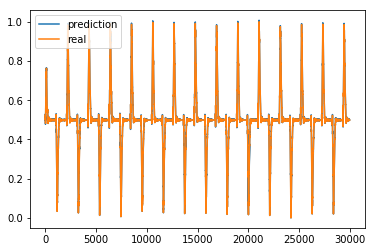

In [154]:
from matplotlib  import pyplot  as plt
fig, ax=plt.subplots()
ax.plot(list(pred1[:,1]), label='prediction')
ax.plot(list(y[:,1]), label='real')
plt.legend()
plt.show()

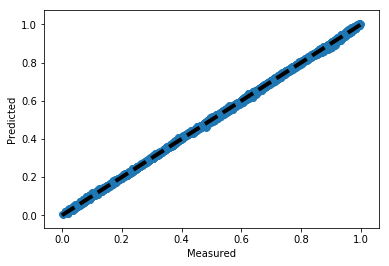

In [155]:
fig, ax=plt.subplots()
ax.scatter(y[:,1],pred1[:,1])
ax.plot([y[:,1].min(), y[:,1].max()],[y[:,1].min(), y[:,1].max()],'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

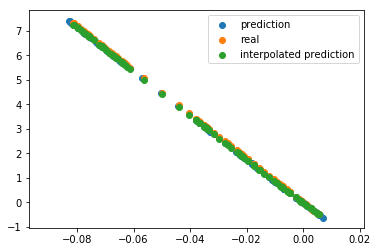

In [156]:
# we compare some points, each with its velocity and force, from pred and real data
fig, ax=plt.subplots()
ax.scatter(pred1_back[:100,0],pred1_back[:100,1],label='prediction')
ax.scatter(test["velocity"][timestep:100+timestep],test["force"][timestep:100+timestep],label='real')
ax.scatter(test["velocity"][timestep:100+timestep],interp_pred[:100],label='interpolated prediction')
plt.legend()
plt.show()

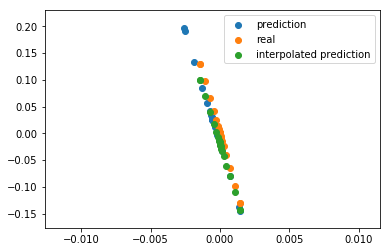

In [157]:
fig, ax=plt.subplots()
ax.scatter(pred1_back[900:1000,0],pred1_back[900:1000,1],label='prediction')
ax.scatter(test["velocity"][900+timestep:1000+timestep],test["force"][900+timestep:1000+timestep],label='real')
ax.scatter(test["velocity"][900+timestep:1000+timestep],interp_pred[900:1000],label='interpolated prediction')
plt.legend()
plt.show()

In [159]:
pd.DataFrame({'real':list(test["force"][timestep:]),'pred':list(pred1_back[:,1]),'interp pred':list(interp_pred[:])} ) .to_csv('train_data_lstmyusra.csv',index=False)

In [61]:


#model.save('train_data_lstm_yusra.h5')

